In [1]:
# Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Resising transforming to tensor and normalizing to [-1, 1]
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=128, shuffle=True)

In [4]:
# Function to show a batch
def show_batch(images, labels):
  fig, ax = plt.subplots(4, 8, figsize=(16, 8))
  images, labels = next(iter(data_loader))
  for i in range(32):
    image, label = images[i], labels[i]
    row = i // 8
    col = i % 8
    ax[row, col].imshow(image[0], cmap='gray')
    ax[row, col].set_title(f'{label}')
  plt.tight_layout()
  plt.show()

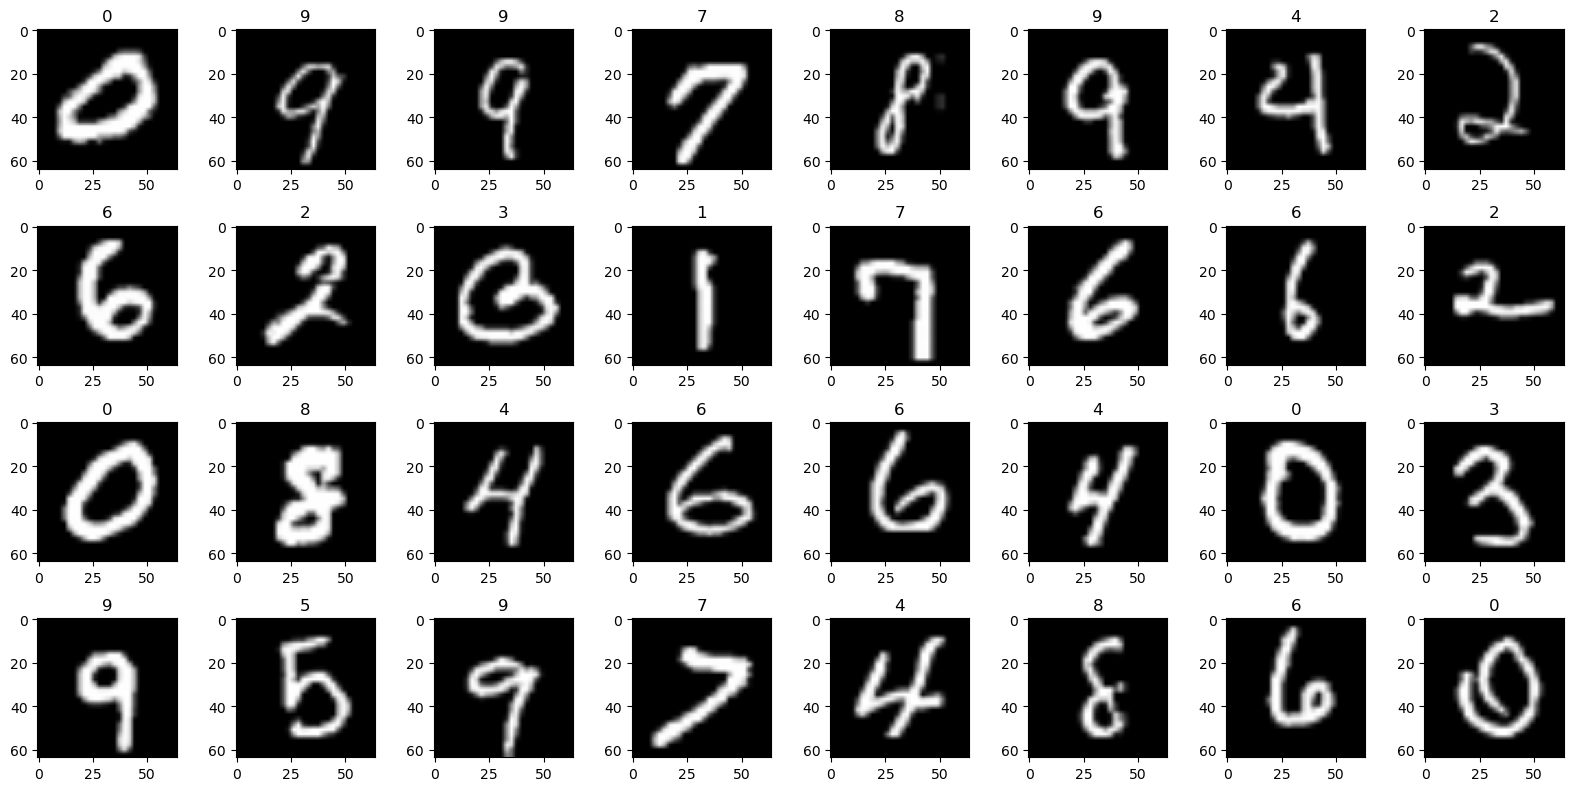

In [5]:
images, labels = next(iter(data_loader))
show_batch(images, labels)

In [7]:
class CreateGenerator(nn.Module):
  def __init__(self):
    super(CreateGenerator, self).__init__()
    self.deconv1 = nn.ConvTranspose2d(in_channels=100, out_channels=1024, kernel_size=4, stride=1, padding=0)
    self.deconv1_bn = nn.BatchNorm2d(1024)

    self.deconv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
    self.deconv2_bn = nn.BatchNorm2d(512)

    self.deconv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
    self.deconv3_bn = nn.BatchNorm2d(256)

    self.deconv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
    self.deconv4_bn = nn.BatchNorm2d(128)
    
    self.deconv5 = nn.ConvTranspose2d(128, 1, 4, 2, 1)
    
  def weight_init(self, mean, std):
    for m in self._modules:
      if isinstance(self._modules[m], nn.ConvTranspose2d) or isinstance(self._modules[m], nn.Conv2d):
        self._modules[m].weight.data.normal_(mean, std)
        self._modules[m].bias.data.zero_()

  def forward(self, x):
    x = F.relu(self.deconv1_bn(self.deconv1(x)))
    x = F.relu(self.deconv2_bn(self.deconv2(x)))
    x = F.relu(self.deconv3_bn(self.deconv3(x)))
    x = F.relu(self.deconv4_bn(self.deconv4(x)))
    x = F.tanh(self.deconv5(x))
    return x

In [8]:
generator = CreateGenerator()
generator.to(device)

CreateGenerator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [9]:
def show_generated_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    for i, image in enumerate(images):
        axes[i].imshow(np.squeeze(image.detach().cpu().numpy()), cmap='gray')
        axes[i].axis('off')
    plt.show()

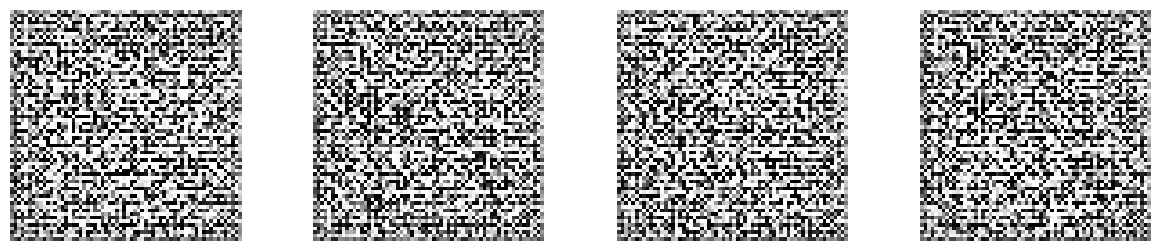

In [10]:
img = generator.forward(torch.rand(4, 100, 1, 1).to(device))
show_generated_images(img)

In [2]:
class CreateDiscriminator(nn.Module):
  def __init__(self):
    super(CreateDiscriminator, self).__init__()
    self.conv1 = nn.Conv2d(1, 128, 4, 2, 1)

    self.conv2 = nn.Conv2d(128, 256, 4, 2, 1)
    self.conv2_bn = nn.BatchNorm2d(256)

    self.conv3 = nn.Conv2d(256, 512, 4, 2, 1)
    self.conv3_bn = nn.BatchNorm2d(512)

    self.conv4 = nn.Conv2d(512, 1024, 4, 2, 1)
    self.conv4_bn = nn.BatchNorm2d(1024)
    
    self.conv5 = nn.Conv2d(1024, 1, 4, 1, 0)

  def weight_init(self, mean, std):
    for m in self._modules:
      if isinstance(self._modules[m], nn.ConvTranspose2d) or isinstance(self._modules[m], nn.Conv2d):
        self._modules[m].weight.data.normal_(mean, std)
        self._modules[m].bias.data.zero_()
          
  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
    x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
    x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
    x = F.sigmoid(self.conv5(x))
    return x

In [5]:
discriminator = CreateDiscriminator()
discriminator.to(device)

CreateDiscriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [ ]:
# Function to save a 10x10 grid of images as epochx 
def save_batch_after_epoch(images, epoch):
  fig, ax = plt.subplots(10, 10, figsize=(12, 12))
  for i in range(100):
    row = i // 10
    col = i % 10
    ax[row, col].imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
  plt.tight_layout()
  plt.savefig(f'epoch{epoch}.png')
  plt.close()

In [ ]:
# Initializing the generator, discriminator and the weights
generator = CreateGenerator()
discriminator = CreateDiscriminator()
generator.weight_init(mean=0.0, std=0.02)
discriminator.weight_init(mean=0.0, std=0.02)
generator.to(device)
discriminator.to(device)

# learning rate and #of epochs we want to train for
lr = 0.0002
train_epoch = 20

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Generating random noise generate images from after each epoch
images_noise = torch.rand(100, 100, 1, 1).to(device)

In [ ]:
for epoch in range(train_epoch):
    counter = 0
    # Generating images after each epoch
    with torch.no_grad():
      imgages_to_save = generator.forward(images_noise)
      save_batch_after_epoch(imgages_to_save, epoch)
    for img, _ in data_loader:
        img = img.to(device)
        mini_batch = img.size()[0]

        # Train discriminator
        discriminator.zero_grad()

        # Creating labels for the discriminator and adding some noise to prevent the discriminator from converging to fast
        random_noise = torch.randn(mini_batch).to(device) * 0.05
        label_real = torch.clamp(torch.ones(mini_batch).to(device) - random_noise, 0, 1)
        label_fake = torch.clamp(torch.zeros(mini_batch).to(device) + random_noise, 0, 1)

        # Real loss
        D_result = discriminator(img).squeeze()
        D_real_loss = BCE_loss(D_result, label_real)
        D_real_score = D_result.data.mean()
        
        # Generate images
        noise = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).to(device)
        G_result = generator(noise)

        # Fake loss
        D_result = discriminator(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, label_fake)
        D_fake_score = D_result.data.mean()

        # Loss, .backward, step
        D_train_loss = D_real_loss + D_fake_loss
        D_train_loss.backward()
        D_optimizer.step()

        # Train generator
        generator.zero_grad()

        # Generate images and 'rate' them with discriminator
        noise = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).to(device)
        G_result = generator(noise)
        D_result = discriminator(G_result).squeeze()

        # Loss, .backward, step
        G_train_loss = BCE_loss(D_result, label_real)
        G_train_loss.backward()
        G_optimizer.step()

        counter = counter + 1
        if (counter+1) % 50 == 0:
          print(f'Epoch [{epoch+1}/{train_epoch}], Step [{counter+1}/{len(data_loader)}], '
                f'D_loss: {D_train_loss.item():.4f}, G_loss: {G_train_loss.item():.4f}, '
                f'D(x): {D_real_score:.2f}, D(G(z)): {D_fake_score:.2f}')